In [1]:
# 数値計算に使うライブラリ
import numpy as np
import pandas as pd
from scipy import stats

# グラフを描画するライブラリ
from matplotlib import pyplot as plt
import seaborn as sns

sns.set()

# 統計モデルを推定するライブラリ
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
import statsmodels.formula.api as smf
import pmdarima as pm

# 予測
from sktime.forecasting.arima import AutoARIMA

# 予測の評価指標
from sktime.performance_metrics.forecasting import (
    mean_absolute_scaled_error,
    MeanAbsoluteError,
    mean_absolute_percentage_error,
    mean_absolute_error,
)

# グラフの日本語表記
from matplotlib import rcParams

rcParams["font.family"] = "IPAexGothic"
rcParams["font.sans-serif"] = "Meiryo"

In [2]:
# 表示設定
np.set_printoptions(linewidth=60)
pd.set_option("display.width", 80)

from matplotlib.pylab import rcParams

rcParams["figure.figsize"] = 8, 4

In [3]:
# データの読み込み
ts_sales_bj = pd.read_csv(
    "4-3-1-sales-data.csv",  # ファイル名
    index_col="date",  # インデックスとして扱う列名
    parse_dates=True,  # インデックスを「時間軸」として扱う
    dtype="float",  # データの型(浮動小数点)
)

ts_sales_bj.index.freq = "MS"

# 訓練データとテストデータに分割する
train = ts_sales_bj.loc["2010-01":"2018-12"]
test = ts_sales_bj.loc["2019-01":"2019-12"]

In [4]:
# これは間違い
pm.arima.ndiffs(np.log(train["sales"]), test="kpss")

1

In [5]:
# これは間違い
pm.arima.nsdiffs(np.log(train["sales"]), m=12, test="ocsb")

0

In [6]:
# ---------------------------------------------
# 線形回帰モデル（OLS: Ordinary Least Squares）
# ---------------------------------------------
# 売上(sales)を対数変換し、割引(discount)を説明変数として
# 回帰分析を行う。
# ここで対数を取るのは、売上データの分布を正規分布に近づけ、
# 変動率（%変化）を扱いやすくするため。

ols_model = smf.ols("np.log(sales) ~ discount", data=train).fit()

# ---------------------------------------------
# 残差（residuals）の取得
# ---------------------------------------------
# 残差とは、「実際の値」と「モデルの予測値」の差。
# ARIMA/SARIMAXなどの時系列モデルにこの残差を入力すると、
# トレンドや季節性を取り除いた“純粋な変動部分”を扱える。
ols_resid = ols_model.resid

# ---------------------------------------------
# 残差の確認（最初の3行を表示）
# ---------------------------------------------
print(ols_resid.head(3))

date
2010-01-01   -0.025589
2010-02-01   -0.083576
2010-03-01   -0.129386
dtype: float64


In [7]:
# --------------------------------------------------
# 残差に対して単位根検定を行い、必要な差分次数 d を求める
# --------------------------------------------------
# test='kpss'：KPSS検定（帰無仮説＝定常）を使う。
# KPSS の場合、p値が小さいほど「非定常」と判断されるため、
# 差分を1回ずつ取り、定常と判断されるまで繰り返す。
# この結果が ARIMA モデルの d に対応する。

import pmdarima as pm

d = pm.arima.ndiffs(ols_resid, test="kpss")

print(f"推定された差分次数 d：{d}")

推定された差分次数 d：1


In [8]:
# --------------------------------------------------
# 残差に対して季節差分が必要かを検定する
# --------------------------------------------------
# test='ocsb'：OCSB検定（Osborn, Chui, Smith & Birchenhall, 1988）を利用。
#   帰無仮説：季節差分は不要（すでに季節的に定常）
#   対立仮説：季節差分が必要（季節的非定常）
# m=12 は「季節周期＝12（例：月次データ）」を意味する。
# 結果として返される値（通常は 0 または 1）が、
# SARIMA モデルの季節差分次数 D の推定値となる。
import pmdarima as pm

D = pm.arima.nsdiffs(ols_resid, m=12, test="ocsb")
print(f"推定された季節差分次数 D：{D}")

推定された季節差分次数 D：1


In [9]:
# --------------------------------------------------
# SARIMAXモデルの自動選択（Auto ARIMA）
# --------------------------------------------------
mod_sarimax_best = pm.arima.auto_arima(
    y=np.log(train["sales"]),  # 対数変換した売上データ（系列の分散を安定化）
    X=train["discount"].values.reshape(-1, 1),  # 外生変数（割引情報）
    # --- 階差に関する設定 ---
    test="kpss",  # KPSS検定：トレンド非定常性の検出（差分次数 d を自動決定）
    seasonal_test="ocsb",  # OCSB検定：季節単位の非定常性を検出（季節差分次数 D を自動決定）
    m=12,  # 季節周期（12ヶ月＝1年）
    # --- モデル選択と次数の探索範囲 ---
    criterion="AIC",  # モデル選択基準（Akaike Information Criterion）
    max_p=2,
    max_q=2,  # AR(p), MA(q) の最大次数
    max_P=2,
    max_Q=2,  # 季節AR(P), 季節MA(Q) の最大次数
    start_p=0,
    start_q=0,
    start_P=0,
    start_Q=0,  # 探索開始次数
    # --- 計算方法 ---
    stepwise=False,  # 総当たり法（stepwise=False）で全候補を探索
    n_jobs=-1,  # 並列処理を有効化（全CPUコア使用）
    maxiter=5000,  # パラメータ推定の最大反復回数
    solver="nm",  # Nelder-Mead法でパラメータ最適化
    # --- モデル構造 ---
    with_intercept=False,  # 切片を含めない（既に対数変換済みかつ外生変数ありのため）
)

In [10]:
print(mod_sarimax_best.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  108
Model:             SARIMAX(1, 1, 0)x(0, 1, 0, 12)   Log Likelihood                  77.949
Date:                            Wed, 15 Oct 2025   AIC                           -149.898
Time:                                    20:12:29   BIC                           -142.236
Sample:                                01-01-2010   HQIC                          -146.802
                                     - 12-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.7762      0.023     33.210      0.000       0.730       0.822
ar.L1         -0.4453      0.087   

In [11]:
# --------------------------------------------------
# Auto ARIMA により、すべての候補モデルを探索・保持
# --------------------------------------------------
mod_sarimax_list = pm.arima.auto_arima(
    y=np.log(train["sales"]),  # 対数変換した売上データ（分散安定化）
    X=train["discount"].values.reshape(-1, 1),  # 外生変数（割引率）
    # --- 階差設定 ---
    test="kpss",  # KPSS検定：トレンド非定常性の検出 → 通常差分 d を決定
    seasonal_test="ocsb",  # OCSB検定：季節単位の非定常性を検出 → 季節差分 D を決定
    m=12,  # 季節周期：12ヶ月
    # --- モデル次数の探索範囲 ---
    criterion="AIC",  # モデル選択基準：AIC（情報量基準）
    max_p=2,
    max_q=2,  # AR(p), MA(q) の最大次数
    max_P=2,
    max_Q=2,  # 季節AR(P), 季節MA(Q) の最大次数
    start_p=0,
    start_q=0,
    start_P=0,
    start_Q=0,  # 開始次数
    # --- 探索方法と最適化 ---
    stepwise=False,  # stepwise探索を無効化 → 総当たり法で全モデル評価
    n_jobs=-1,  # 並列実行（利用可能なCPUコアを全て使用）
    maxiter=5000,  # 最大反復回数
    solver="nm",  # パラメータ推定：Nelder-Mead法
    with_intercept=False,  # 切片なし（外生変数あり）
    # --- すべてのモデル結果を保持 ---
    return_valid_fits=True,  # Trueにすることで、候補モデルすべての結果を取得可能
)

In [12]:
# =========================================================
#  各モデルのAICをDataFrameにまとめ、昇順に並べる
# =========================================================
result_df = pd.DataFrame(
    {
        "model": np.tile("", len(mod_sarimax_list)),  # モデル式を格納
        "AIC": np.zeros(len(mod_sarimax_list)),  # AIC値を格納
    }
)

# 各モデルの情報をDataFrameに記録
for i in range(len(mod_sarimax_list)):
    result_df.iloc[i, 0] = str(mod_sarimax_list[i])  # モデル式を文字列として保存
    result_df.iloc[i, 1] = mod_sarimax_list[i].aic()  # AIC値を保存

# AICの小さい順に並べて表示（良いモデルほど上にくる）
print(result_df.sort_values("AIC", ascending=True))

                                 model         AIC
0    ARIMA(1,1,0)(0,1,0)[12]           -149.897609
1    ARIMA(0,1,1)(0,1,0)[12]           -149.043075
2    ARIMA(1,1,1)(0,1,0)[12]           -148.459464
3    ARIMA(0,1,2)(0,1,0)[12]           -148.440131
4    ARIMA(2,1,0)(0,1,0)[12]           -148.364485
5    ARIMA(1,1,0)(0,1,1)[12]           -148.313625
6    ARIMA(1,1,0)(1,1,0)[12]           -148.310737
7    ARIMA(0,1,1)(0,1,1)[12]           -147.510976
8    ARIMA(0,1,1)(1,1,0)[12]           -147.487735
9    ARIMA(0,1,1)(2,1,2)[12]           -147.368297
10   ARIMA(1,1,1)(0,1,1)[12]           -146.706143
11   ARIMA(1,1,1)(1,1,0)[12]           -146.702859
12   ARIMA(0,1,2)(0,1,1)[12]           -146.677925
13   ARIMA(0,1,2)(1,1,0)[12]           -146.676053
14   ARIMA(2,1,0)(0,1,1)[12]           -146.634324
15   ARIMA(2,1,0)(1,1,0)[12]           -146.631508
16   ARIMA(1,1,2)(0,1,0)[12]           -146.444433
17   ARIMA(2,1,1)(0,1,0)[12]           -146.439380
18   ARIMA(1,1,0)(2,1,0)[12]   

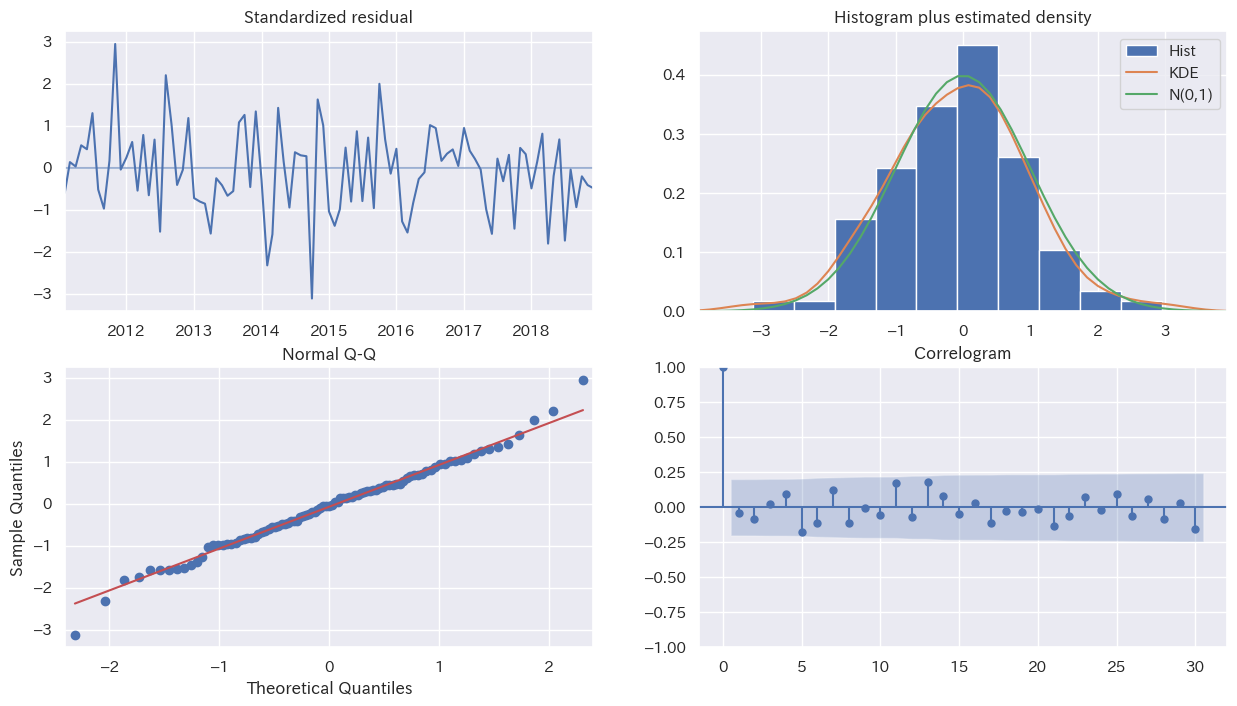

In [13]:
# 残差診断プロット
_ = mod_sarimax_best.plot_diagnostics(lags=30, figsize=(15, 8))

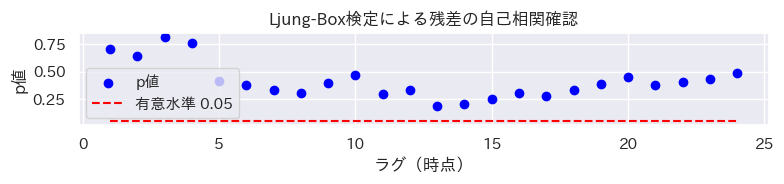

In [14]:
# =====================================================
# 残差の自己相関の検定（Ljung-Box検定）
# =====================================================

# Ljung-Box検定を利用して、残差の自己相関を確認
# 1時点前から24時点前まで、1つずつラグを増やしながら検定を実施
res_test = mod_sarimax_best.arima_res_.test_serial_correlation(
    method="ljungbox", lags=24
)

# グラフサイズとレイアウトを指定
fig, ax = plt.subplots(figsize=(8, 2), tight_layout=True)

# 各ラグにおけるp値を散布図として描画
ax.scatter(np.arange(1, 25), res_test[0][1], color="blue", label="p値")

# 有意水準（α=0.05）のラインを赤線で表示
ax.plot(
    np.arange(1, 25),
    np.tile(0.05, 24),
    color="red",
    linestyle="--",
    label="有意水準 0.05",
)

# 軸ラベルと凡例を設定
ax.set_xlabel("ラグ（時点）")
ax.set_ylabel("p値")
ax.set_title("Ljung-Box検定による残差の自己相関確認")
ax.legend()

In [16]:
# =====================================================
# 残差の正規性の検定（Jarque-Bera検定）
# =====================================================

# Jarque-Bera検定を実施
# 出力は (JB統計量, p値, 歪度, 尖度)
jb_test = mod_sarimax_best.arima_res_.test_normality(method="jarquebera")

# 結果の表示
print(f"JB統計量 : {jb_test[0][0]:.3f}")
print(f"p値      : {jb_test[0][1]:.3f}")
print(f"歪度     : {jb_test[0][2]:.3f}")
print(f"尖度     : {jb_test[0][3]:.3f}")

JB統計量 : 1.330
p値      : 0.514
歪度     : -0.015
尖度     : 3.579


In [17]:
# 予測期間
fh = np.arange(1, len(test) + 1)

# データの変換
train_period = train.to_period()
test_period = test.to_period()

In [ ]:
# =====================================================
# 自動ARIMAモデル（AutoARIMA）の設定と学習
# =====================================================

# 予測手法の指定（ARIMAモデルの自動同定）
arima_forecaster = AutoARIMA(
    test="kpss",  # KPSS検定で差分階数 d を決定（定常性の確認）
    seasonal_test="ocsb",  # OCSB検定で季節差分階数 D を決定
    information_criterion="aic",  # AICを基準に最良モデルを選択
    sp=12,  # 季節周期（12ヶ月周期）
    max_p=2,
    max_q=2,
    max_P=2,
    max_Q=2,  # AR・MA・季節AR・季節MAの最大次数
    start_p=0,
    start_q=0,
    start_Q=0,
    start_P=0,  # 最小次数（探索の起点）
    stepwise=False,  # ステップワイズ法を使わず、全探索でAIC最小のモデルを探索
    n_jobs=-1,  # CPUコアを最大限使用して並列計算
    maxiter=5000,  # パラメータ推定時の最大反復回数を5000に設定
    with_intercept=False,  # 定数項（切片）を含めないモデルを採用
    method="nm",  # パラメータ最適化にNelder-Mead法を使用
)

# モデルの学習
# 対数変換した売上データを目的変数として、割引率を外生変数（説明変数）に設定
arima_forecaster.fit(
    y=np.log(train_period["sales"]),  # 対数変換済み売上データ
    X=train_period["discount"],  # 外生変数（割引率）
)

In [19]:
# 予測の実施
sarimax_fore = arima_forecaster.predict(fh, X=test_period["discount"])

# 予測精度
mean_absolute_error(test_period["sales"], sarimax_fore)

25.240766610356214